## Topic Modeling with Latent Dirichlet Allocation

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from pathlib import Path
import os
import glob

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.io.json import json_normalize
import json

import pprint
import string

import matplotlib.pyplot as plt
import seaborn as sns

import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk('C:/Users/trivikram.cheedella/OneDrive - JD Power/Data Science Data/CORD-19-research-challenge'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

# for filename in fnmatch.filter(filenames, '*.txt'):
# Any results you write to the current directory are saved as output.

In [2]:
input = Path('C:/Users/trivikram.cheedella/OneDrive - JD Power/Data Science Data/CORD-19-research-challenge')
output = Path('C:/Users/trivikram.cheedella/OneDrive - JD Power/Data Science Data/CORD-19-research-challenge/output')

comm_use_subset = Path('C:/Users/trivikram.cheedella/OneDrive - JD Power/Data Science Data/CORD-19-research-challenge/comm_use_subset/comm_use_subset')


## Load the meta data file

In [3]:
df_all_sources_metadata = pd.read_csv(input / 'metadata.csv')

In [4]:
print(df_all_sources_metadata.shape)
df_all_sources_metadata.info()

(45774, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45774 entries, 0 to 45773
Data columns (total 17 columns):
cord_uid                       45774 non-null object
sha                            31753 non-null object
source_x                       45774 non-null object
title                          45617 non-null object
doi                            42440 non-null object
pmcid                          26243 non-null object
pubmed_id                      34641 non-null float64
license                        45774 non-null object
abstract                       37913 non-null object
publish_time                   45765 non-null object
authors                        43774 non-null object
journal                        41707 non-null object
Microsoft Academic Paper ID    964 non-null float64
WHO #Covidence                 1768 non-null object
has_full_text                  45774 non-null bool
full_text_file                 35558 non-null object
url                            454

In [5]:
df_all_sources_metadata.head(3)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866


In [6]:
pd.pivot_table(df_all_sources_metadata, index='full_text_file', values=['sha', 'source_x', 'has_full_text'], aggfunc={'sha': 'count', 'source_x': 'count', 'has_full_text': np.sum}, margins=True)

,has_full_text,sha,source_x
full_text_file,,,
biorxiv_medrxiv,1053.0,1053,1218
comm_use_subset,8864.0,8864,8982
custom_license,19816.0,19816,23227
noncomm_use_subset,2020.0,2020,2131
All,31753.0,31753,31753


## ReadIn the JSON Files

The following code for reading in the JSON file is taken from the notebook <b>COVID EDA: Initial Exploration Tool</b> by <i><b>Ivan Ega Pratama</b></i>

https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool

In [7]:
%%time
all_json = glob.glob(f'{comm_use_subset}/**/*.json', recursive=True)
len(all_json)

Wall time: 267 ms


9315

In [8]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
            # Extend Here
            #
            #
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

000b7d1517ceebb34e1e3e817695b6de03e2fa78: ... - Figure S1 : Phylogeny of all sequences belonging to the UMRV phylogroup. - Table S4 : Bats cytochrome b sequences data set. -Table S5 : Test of host-parasite co-evolution using global fit methods Pa...


In [9]:
%%time
dict_ = {'paper_id': [], 'abstract': [], 'body_text': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    content = FileReader(entry)
    dict_['paper_id'].append(content.paper_id)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text'])
df_covid.head()

Processing index: 0 of 9315
Processing index: 931 of 9315
Processing index: 1862 of 9315
Processing index: 2793 of 9315
Processing index: 3724 of 9315
Processing index: 4655 of 9315
Processing index: 5586 of 9315
Processing index: 6517 of 9315
Processing index: 7448 of 9315
Processing index: 8379 of 9315
Processing index: 9310 of 9315
Wall time: 56 s


,paper_id,abstract,body_text
0,000b7d1517ceebb34e1e3e817695b6de03e2fa78,,- Figure S1 : Phylogeny of all sequences belon...
1,00142f93c18b07350be89e96372d240372437ed9,Dendritic cells (DCs) are specialized antigen-...,iNTRODUCTiON Human beings are constantly expos...
2,0022796bb2112abd2e6423ba2d57751db06049fb,Dengue has a negative impact in low-and lower ...,Pathogens and vectors can now be transported r...
3,0031e47b76374e05a18c266bd1a1140e5eacb54f,"Fecal microbial transplantation (FMT), a treat...",a1111111111 a1111111111 a1111111111 a111111111...
4,00326efcca0852dc6e39dc6b7786267e1bc4f194,"Fifteen years ago, United Nations world leader...",In addition to preventative care and nutrition...


In [10]:
dict_ = None

In [11]:
%%time
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))
df_covid.head()

Wall time: 6.71 s


,paper_id,abstract,body_text,abstract_word_count,body_word_count
0,000b7d1517ceebb34e1e3e817695b6de03e2fa78,,- Figure S1 : Phylogeny of all sequences belon...,0,112
1,00142f93c18b07350be89e96372d240372437ed9,Dendritic cells (DCs) are specialized antigen-...,iNTRODUCTiON Human beings are constantly expos...,309,5305
2,0022796bb2112abd2e6423ba2d57751db06049fb,Dengue has a negative impact in low-and lower ...,Pathogens and vectors can now be transported r...,276,7288
3,0031e47b76374e05a18c266bd1a1140e5eacb54f,"Fecal microbial transplantation (FMT), a treat...",a1111111111 a1111111111 a1111111111 a111111111...,141,4669
4,00326efcca0852dc6e39dc6b7786267e1bc4f194,"Fifteen years ago, United Nations world leader...",In addition to preventative care and nutrition...,151,7593


In [12]:
df_covid.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
paper_id,9315,9315,b38901ead62c88fd24f7d28ca738711e13fb79ad,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abstract,9315,8318,,942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body_text,9315,9258,Coronavirus disease 2019 (COVID-2019) has been...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abstract_word_count,9315,NaN,NaN,NaN,232.881,181.984,0,150,216,287,3694
body_word_count,9315,NaN,NaN,NaN,4520.88,3473.55,1,2926,4109,5691,171948


In [13]:
df_covid.drop_duplicates(['body_text'], inplace=True)
df_covid.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
paper_id,9258,9258,b38901ead62c88fd24f7d28ca738711e13fb79ad,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abstract,9258,8318,,921,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body_text,9258,9258,The gut microbiome of an animal consists of ba...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abstract_word_count,9258,NaN,NaN,NaN,233.491,182.122,0,150,216,288,3694
body_word_count,9258,NaN,NaN,NaN,4526.69,3477.92,1,2935.25,4113.5,5695,171948


## Clean up the text

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS

In [15]:
lemmatizer = WordNetLemmatizer()

print("Number of stopwrods from STOPWORDS: ", len(STOPWORDS))
print("Number of stopwrods from stopwords.words('english'): ", len(stopwords.words('english')))
other_stopwords = ['q', 'license', 'preprint', 'copyright', 'http', 'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'fig', 'fig.', 'al.', 'di', 'la', 'il', 'del', 'le', 'della', 'dei', 'delle', 'una', 'da',  'dell',  'non', 'si', 'cc']
custom_stopwords = []
custom_stopwords = list(set(stopwords.words('english') + list(STOPWORDS))) + other_stopwords

print("Number of stopwrods from custom_stopwords: ", len(custom_stopwords))
print(custom_stopwords[-25:])

Number of stopwrods from STOPWORDS:  190
Number of stopwrods from stopwords.words('english'):  179
Number of stopwrods from custom_stopwords:  264
['author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'fig', 'fig.', 'al.', 'di', 'la', 'il', 'del', 'le', 'della', 'dei', 'delle', 'una', 'da', 'dell', 'non', 'si', 'cc']


In [16]:
def clean_the_text(text):
        text = re.sub('[^a-zA-Z0-9-]', ' ', text)
        tokens = word_tokenize(text)
        # remove_punc = [word for word in tokens if word not in string.punctuation]
        remove_stopwords = [word.lower() for word in tokens if word.lower() not in custom_stopwords]
        more_than_three = [w for w in remove_stopwords if len(w)>3]
        lem = [lemmatizer.lemmatize(w) for w in more_than_three]
        return ' '.join(lem)

# cleaned_text = clean_the_text("my name is TRIVIKRAM, and I am first born in my fam don't process processing patients")
# print(cleaned_text)

In [17]:
df_covid_for_nlp = df_covid.copy()
df_covid = None

In [18]:
%%time
df_covid_for_nlp['cleaned_text'] = df_covid_for_nlp['body_text'].apply(lambda x: clean_the_text(x))

Wall time: 14min 38s


In [19]:
df_covid_for_nlp['cleaned_text'].head()

0    phylogeny sequence belonging umrv phylogroup t...
1    introduction human being constantly exposed my...
2    pathogen vector transported rapidly around wor...
3    a1111111111 a1111111111 a1111111111 a111111111...
4    addition preventative care nutritional support...
Name: cleaned_text, dtype: object

In [ ]:
# placeholder cell to sub-set data
# df_covid_for_nlp_10K = df_covid_for_nlp.head(10000).copy()
# df_covid_for_nlp_10K.shape

# Topic Modeling using Latent Dirichlet Allocation (LDA)

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

### Convert the text data to Term frequency - Inverse Document frequency

In [21]:
%%time 

tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix_Tfidf = tfidf_vect.fit_transform(df_covid_for_nlp['cleaned_text'].values.astype('U'))

Wall time: 5min 26s


In [22]:
doc_term_matrix_Tfidf

<9258x103975 sparse matrix of type '<class 'numpy.float64'>'
	with 6952610 stored elements in Compressed Sparse Row format>

### Use GridSearchCV to find the best parameters for LDA

In [23]:
%%time
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30, 50], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
grid_search_model = GridSearchCV(lda, param_grid=search_params, n_jobs=-1)

# Do the Grid Search
grid_search_model.fit(doc_term_matrix_Tfidf)

Wall time: 1h 50min 38s


GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [24]:
# Best Model
best_lda_model = grid_search_model.best_estimator_

# Model Parameters
print("Best Model's Params: ", grid_search_model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", grid_search_model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_term_matrix_Tfidf))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -284521.9448366463
Model Perplexity:  53746.09741005486


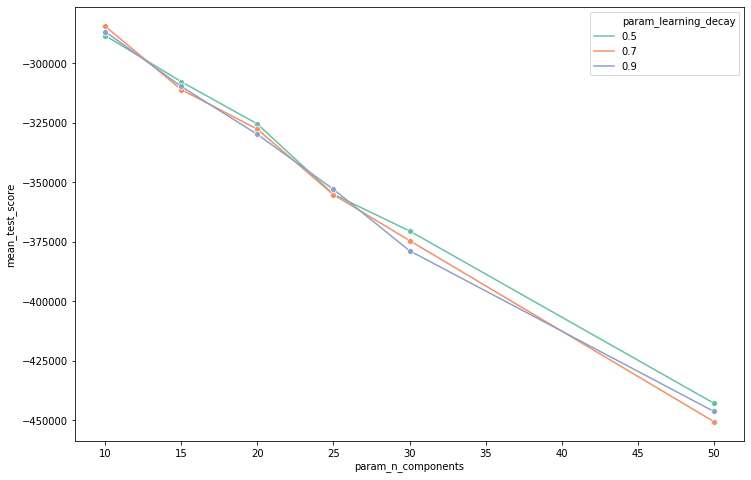

In [25]:
df_results = pd.DataFrame(grid_search_model.cv_results_)

current_palette = sns.color_palette("Set2", 3)

plt.figure(figsize=(12,8))

sns.lineplot(data=df_results,
             x='param_n_components',
             y='mean_test_score',
             hue='param_learning_decay',
             palette=current_palette,
             marker='o')

plt.show()

### Getting 10 random features

In [26]:
import random

for i in range(10):
    random_id = random.randint(0,len(tfidf_vect.get_feature_names()))
    print(tfidf_vect.get_feature_names()[random_id])

merkel
candidatus
loop2
fj621583
eurotium
correlations
phd
fisman
catalysis
hcn


### Print the top 10 words from the first topic

In [27]:
first_topic = best_lda_model.components_[0]

In [28]:
top_topic_words = first_topic.argsort()[-10:]
top_topic_words

array([11376, 61930, 49025, 19510, 64156, 96530, 83278, 47262, 14440,
       20218], dtype=int64)

In [29]:
for i in top_topic_words:
    print(tfidf_vect.get_feature_names()[i])

amirna
mimopro
iir915
bzip60
mupyv
trem2
rn
hrid
auris
caninecv


### Print the top 10 words topic wise

In [30]:
for i,topic in enumerate(best_lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['amirna', 'mimopro', 'iir915', 'bzip60', 'mupyv', 'trem2', 'rn', 'hrid', 'auris', 'caninecv']


Top 10 words for topic #1:
['dvgs', 'mt145k', 'cvcva5', 'mrmp', '31ca', 'chws', 'dnai1', 'gnp', 'apod', 'egr']


Top 10 words for topic #2:
['year', 'risk', 'model', 'outbreak', 'child', 'respiratory', 'health', 'influenza', 'case', 'patient']


Top 10 words for topic #3:
['genome', 'strain', 'antibody', 'expression', 'sequence', 'mouse', 'viral', 'gene', 'protein', 'cell']


Top 10 words for topic #4:
['n214a', 'api5', 's185', 'afp', 'evp40', 'casd1', 'iift', 'tsl', 'eri3', 'ypfs']


Top 10 words for topic #5:
['binase', 'ppg', 'coe', 'eplex', 'm41', 'sonfh', 'pcp', 'beau', 'carrageenan', 'beaur']


Top 10 words for topic #6:
['ocugt1', 'lfd', 'hids', 'ns3pro', 'vaca', 'rscv', 'bamv', 'emr2', 'tfr1', 'sgta']


Top 10 words for topic #7:
['ivdc1', 'pqss', 'diub', 'ra59', 'exndi', 'phytol', 'ceacams', 'ceacam', 'acherv', 'ceacam1']


Top 10 words for topic #8:
['hb

### Find the most dominant topic in each document

In [31]:
topic_values_tfidf = best_lda_model.transform(doc_term_matrix_Tfidf)
topic_values_tfidf.shape

(9258, 10)

In [32]:
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

rows = df_covid_for_nlp['paper_id']

In [33]:
df_topic_values_tfidf = pd.DataFrame(topic_values_tfidf, columns=topicnames, index=rows)

In [34]:
df_topic_values_tfidf['topic_number_tfidf'] = topic_values_tfidf.argmax(axis=1)

In [35]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

In [36]:
df_topic_values_tfidf.head(10).style.applymap(color_green).applymap(make_bold)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,topic_number_tfidf
paper_id,,,,,,,,,,,
000b7d1517ceebb34e1e3e817695b6de03e2fa78,0.0169166,0.0169166,0.0169212,0.727999,0.0169166,0.0169166,0.0169166,0.0169166,0.0169166,0.136664,3
00142f93c18b07350be89e96372d240372437ed9,0.00664566,0.00664566,0.0950127,0.851821,0.00664566,0.00664566,0.00664566,0.00664566,0.00664566,0.00664634,3
0022796bb2112abd2e6423ba2d57751db06049fb,0.00584621,0.00584621,0.947317,0.00591339,0.00584621,0.00584621,0.00584628,0.00584622,0.00584621,0.00584622,2
0031e47b76374e05a18c266bd1a1140e5eacb54f,0.00787783,0.00787783,0.585437,0.35154,0.00787783,0.00787783,0.00787783,0.00787783,0.00787783,0.00787783,2
00326efcca0852dc6e39dc6b7786267e1bc4f194,0.00541375,0.00541375,0.951264,0.00542605,0.00541375,0.00541375,0.00541375,0.00541375,0.00541375,0.00541375,2
00352a58c8766861effed18a4b079d1683fec2ec,0.00778979,0.146417,0.00782754,0.791227,0.00778979,0.00778979,0.00778979,0.00778979,0.00778979,0.00779002,3
0043d044273b8eb1585d3a66061e9b4e03edc062,0.00668983,0.00668983,0.939788,0.00669376,0.00668983,0.00668983,0.00668983,0.00668983,0.00668983,0.00668983,2
0049ba8861864506e1e8559e7815f4de8b03dbed,0.00969322,0.00969322,0.00971201,0.912742,0.00969322,0.00969323,0.00969322,0.00969322,0.00969322,0.00969322,3
00623bf2715e25d3acacb3f210d6888ed840e3cb,0.0111856,0.0111856,0.0111879,0.899326,0.0111856,0.0111856,0.0111856,0.0111856,0.0111856,0.0111861,3


### Create a dataframe for the 10 topics

In [37]:
dict_topic = {'topic_number_tfidf': [], 'topic_words_tfidf': []}

for i,topic in enumerate(best_lda_model.components_):
    dict_topic['topic_number_tfidf'].append(i)
    dict_topic['topic_words_tfidf'].append([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])

df_covid_topics_tfidf = pd.DataFrame(dict_topic, columns=['topic_number_tfidf', 'topic_words_tfidf'])
df_covid_topics_tfidf.head(10)

,topic_number_tfidf,topic_words_tfidf
0,0,"[amirna, mimopro, iir915, bzip60, mupyv, trem2..."
1,1,"[dvgs, mt145k, cvcva5, mrmp, 31ca, chws, dnai1..."
2,2,"[year, risk, model, outbreak, child, respirato..."
3,3,"[genome, strain, antibody, expression, sequenc..."
4,4,"[n214a, api5, s185, afp, evp40, casd1, iift, t..."
5,5,"[binase, ppg, coe, eplex, m41, sonfh, pcp, bea..."
6,6,"[ocugt1, lfd, hids, ns3pro, vaca, rscv, bamv, ..."
7,7,"[ivdc1, pqss, diub, ra59, exndi, phytol, ceaca..."
8,8,"[hbov2, ly6e, rhifitm3, psgs, siba, brbv, aeco..."
9,9,"[chop, cd147, autophagic, autophagosome, atf6,..."


## Visualization using pyLDAvis

The visualization is a learning from the following source

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [38]:
import pyLDAvis
import pyLDAvis.sklearn

In [41]:
%%time

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, doc_term_matrix_Tfidf, tfidf_vect, mds='tsne', sort_topics=False)
panel

C:\Users\trivikram.cheedella\MyInstalledSoftware\Continuum\miniconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Wall time: 1h 25min 57s


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1   0.857470
1       0.648955  71.707100       2        1   0.884309
2      71.019684   9.971006       3        1  37.800012
3       3.785981  33.185135       4        1  54.842922
4     -42.666500  -9.222070       5        1   0.863233
5      -3.621689 -43.526516       6        1   0.912668
6      -3.632402  -4.171708       7        1   0.910004
7     -36.584400  35.804413       8        1   0.889193
8      44.391380  50.615383       9        1   0.905340
9      40.235809 -31.591665      10        1   1.134848, topic_info=      Category        Freq            Term       Total  loglift  logprob
21811  Default  435.000000            cell  435.000000  30.0000  30.0000
77878  Default  261.000000         protein  261.000000  29.0000  29.0000
71788  Default  197.000000         patient  197.000000  28.0000  28.0000
44976  Default  114.000000          health  114.000000  27.0000  27.0000
20804  Default  134.000000            case  134.000000  26.0000  26.0000
...        ...         ...             ...         ...      ...      ...
23021  Topic10    0.386670            chop    2.363647   2.6683  -8.0696
16055  Topic10    0.257612          beclin    0.974984   3.1477  -8.4757
14596  Topic10    0.401908      autophagic    3.205762   2.4022  -8.0310
55844  Topic10    0.383784             lc3    4.475095   2.0225  -8.0771
14604  Topic10    0.300189  autophagosomes    2.975277   2.1850  -8.3228

[491 rows x 6 columns], token_table=        Topic      Freq        Term
term                               
9019        3  0.057256        acid
9019        4  0.944730        acid
9185        3  0.020743  activation
9185        4  0.995649  activation
9203        3  0.152153    activity
...       ...       ...         ...
100867      4  0.791399       viral
101082      3  0.991006       visit
102906     10  1.012939        xbp1
103280      3  0.905541        year
103280      4  0.093217        year

[236 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

### Merge the Topic numbers and top 10 words of each topic to the Meta Data for further analysis

In [42]:
df_covid_for_nlp['topic_number_tfidf'] = topic_values_tfidf.argmax(axis=1)

In [43]:
df_covid_for_nlp.head(3)

,paper_id,abstract,body_text,abstract_word_count,body_word_count,cleaned_text,topic_number_tfidf
0,000b7d1517ceebb34e1e3e817695b6de03e2fa78,,- Figure S1 : Phylogeny of all sequences belon...,0,112,phylogeny sequence belonging umrv phylogroup t...,3
1,00142f93c18b07350be89e96372d240372437ed9,Dendritic cells (DCs) are specialized antigen-...,iNTRODUCTiON Human beings are constantly expos...,309,5305,introduction human being constantly exposed my...,3
2,0022796bb2112abd2e6423ba2d57751db06049fb,Dengue has a negative impact in low-and lower ...,Pathogens and vectors can now be transported r...,276,7288,pathogen vector transported rapidly around wor...,2


In [44]:
df_covid_for_nlp['topic_number_tfidf'].value_counts()

3    5856
2    3384
0       6
6       3
9       3
8       3
5       2
7       1
Name: topic_number_tfidf, dtype: int64

In [45]:
df_covid_for_nlp = df_covid_for_nlp.merge(df_covid_topics_tfidf, how='left', left_on='topic_number_tfidf', right_on='topic_number_tfidf')

In [46]:
df_covid_for_nlp.head(3)

,paper_id,abstract,body_text,abstract_word_count,body_word_count,cleaned_text,topic_number_tfidf,topic_words_tfidf
0,000b7d1517ceebb34e1e3e817695b6de03e2fa78,,- Figure S1 : Phylogeny of all sequences belon...,0,112,phylogeny sequence belonging umrv phylogroup t...,3,"[genome, strain, antibody, expression, sequenc..."
1,00142f93c18b07350be89e96372d240372437ed9,Dendritic cells (DCs) are specialized antigen-...,iNTRODUCTiON Human beings are constantly expos...,309,5305,introduction human being constantly exposed my...,3,"[genome, strain, antibody, expression, sequenc..."
2,0022796bb2112abd2e6423ba2d57751db06049fb,Dengue has a negative impact in low-and lower ...,Pathogens and vectors can now be transported r...,276,7288,pathogen vector transported rapidly around wor...,2,"[year, risk, model, outbreak, child, respirato..."


In [47]:
df_covid_for_nlp.columns

Index(['paper_id', 'abstract', 'body_text', 'abstract_word_count',
       'body_word_count', 'cleaned_text', 'topic_number_tfidf',
       'topic_words_tfidf'],
      dtype='object')

In [48]:
df_all_sources_metadata_with_topics = df_all_sources_metadata.copy()
df_all_sources_metadata_with_topics.shape

(45774, 17)

In [49]:
# df_all_sources_metadata_with_topics = df_all_sources_metadata_with_topics.merge(df_covid_for_nlp_10K[['paper_id', 'topic_count_vector', 'topic_words_count_vector', 'topic_tfidf', 'topic_words_tfidf', 'body_word_count']], how='left', left_on='sha', right_on='paper_id')

df_all_sources_metadata_with_topics = df_all_sources_metadata.merge(
    df_covid_for_nlp[['paper_id', 'abstract_word_count', 'body_word_count', 'cleaned_text', 'topic_number_tfidf', 'topic_words_tfidf']], 
    how='left', 
    left_on='sha', 
    right_on='paper_id')

In [50]:
print(df_all_sources_metadata_with_topics.columns)
print(df_all_sources_metadata_with_topics.shape)
df_all_sources_metadata_with_topics.head()

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_full_text',
       'full_text_file', 'url', 'paper_id', 'abstract_word_count',
       'body_word_count', 'cleaned_text', 'topic_number_tfidf',
       'topic_words_tfidf'],
      dtype='object')
(45774, 23)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,...,WHO #Covidence,has_full_text,full_text_file,url,paper_id,abstract_word_count,body_word_count,cleaned_text,topic_number_tfidf,topic_words_tfidf
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,...,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727,NaN,NaN,NaN,NaN,NaN,NaN
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,...,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889,NaN,NaN,NaN,NaN,NaN,NaN
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,...,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866,NaN,NaN,NaN,NaN,NaN,NaN
3,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,2014-07-25,...,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/007476,NaN,NaN,NaN,NaN,NaN,NaN
4,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,2014-11-11,...,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/010389,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# df_all_sources_metadata_with_topics.to_csv(output / 'df_all_sources_metadata_with_topics_biorxiv.csv', index = False)